# Uitwerkingen Les 2 : Opgave 1 (2e orde)

In [40]:
import plotly.io as pio
pio.renderers.default = "plotly_mimetype"


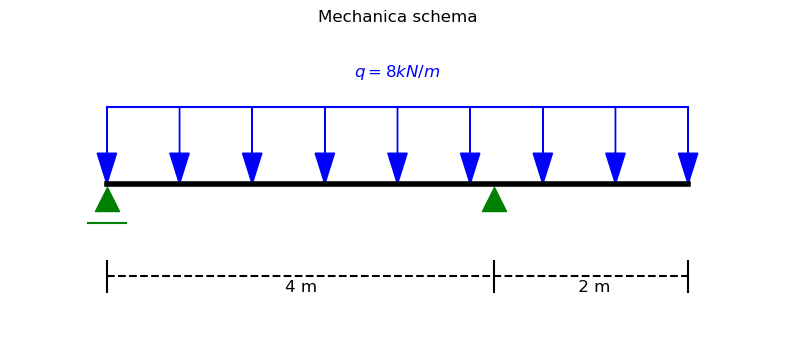

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

# Instellen van de balklengte en belastingen
balk_lengte = 6  # meters
verdeelde_belasting = 8  # kN/m
koppel_locatie = 6  # meters
koppel_waarde = 160  # kNm (met de klok mee)

# Coördinaten van de ondersteuningen
ondersteuning_links = 0  # Rolscharnier
ondersteuning_rechts = 4  # Gewone scharnier

# Instellen van de figuur
fig, ax = plt.subplots(figsize=(10, 4))

# Tekenen van de balk
ax.plot([0, balk_lengte], [0, 0], 'k', lw=4, label="Balk")

# Tekenen van de ondersteuningen als gevulde groene driehoeken
ax.scatter(ondersteuning_links, -0.1, marker='^', s=300, color='green', label="Rolscharnier")
ax.plot([-0.2, 0.2], [-0.25, -0.25], color='green')  # Meetlijn
ax.scatter(ondersteuning_rechts, -0.1, marker='^', s=300, color='green', label="Scharnier")

# Tekenen van de verdeelde belasting met blauwe pijlen en label
x_vals = np.linspace(0, balk_lengte, 9)  
for x in x_vals:
    ax.arrow(x, 0.5, 0, -0.3, head_width=0.2, head_length=0.2, fc='blue', ec='blue')
ax.text(balk_lengte / 2, 0.7, r"$q = 8 kN/m$", fontsize=12, color='blue', ha='center')
ax.plot([0, balk_lengte], [0.5, 0.5], color='blue')  # Meetlijn

# Tekenen van het koppel met cirkelpijlen en blauwe label
#ax.text(koppel_locatie, 0.6, r"$M = 160\ kNm$", fontsize=12, color='blue', ha='center')
#ax.arrow(koppel_locatie - 0.3, 0.2, 0.3, 0.3, head_width=0.1, head_length=0.1, fc='blue', ec='blue', linestyle='dashed')
#ax.arrow(koppel_locatie + 0.3, 0.2, -0.3, 0.3, head_width=0.1, head_length=0.1, fc='blue', ec='blue', linestyle='dashed')

# Tekenen van de maatvoering onder de balk
ax.plot([0, 0], [-0.5, -0.7], 'k')  # Begin meetlijn
ax.plot([4, 4], [-0.5, -0.7], 'k')  # Begin meetlijn
ax.plot([balk_lengte, balk_lengte], [-0.5, -0.7], 'k')  # Eind meetlijn
ax.plot([0, balk_lengte], [-0.6, -0.6], 'k--')  # Meetlijn
ax.text(10 / 2, -0.7, " 2 m", fontsize=12, ha='center')
ax.text(2, -0.7, "4 m", fontsize=12, ha='center')

# Maatvoering voor koppel locatie
#ax.plot([koppel_locatie, koppel_locatie], [-0.5, -0.4], 'k')  # Markering
#ax.text(koppel_locatie, -0.55, "6 m", fontsize=12, ha='center')

# Labels en titel in overeenstemming met template
ax.set_xlim(-1, balk_lengte + 1)
ax.set_ylim(-1, 1)
ax.set_xticks(np.arange(0, balk_lengte + 1, 1))
#ax.set_yticks([])
ax.set_xlabel(r"$x$", color="red", fontsize=14)
ax.set_ylabel(r"$z$", color="red", fontsize=14, rotation=0, labelpad=15)
ax.set_title("Mechanica schema")

# Koppelinstellingen
koppel_locatie = 6  # Positie van het koppel in meters
koppel_radius = 0.6  # Straal van de boog


# Bereken de positie van de pijlpunt op de boog
hoek_pijl = 90  # Pijlpunt bij 270 graden (onderkant boog)
pijl_x = 6.15 #koppel_locatie + (koppel_radius / 2) * np.cos(np.radians(hoek_pijl))
pijl_y = -0.25 #0.3 + (koppel_radius / 2) * np.sin(np.radians(hoek_pijl))

# Pijlpunt toevoegen aan de boog
#ax.add_patch(arc)
#ax.arrow(pijl_x, pijl_y, -0.02, -0.01, head_width=0.1, head_length=0.1, fc='blue', ec='blue')

# Label voor het koppel
#ax.text(koppel_locatie, -.45, r"$M = 160\ kNm$", fontsize=12, color='blue', ha='center')

# Legenda
#ax.legend()

# Assen uitschakelen
ax.axis('off')
#ax.grid()

# Creëer de boog voor het koppel
#arc = patches.Arc((koppel_locatie,-0), koppel_radius, koppel_radius, angle=270, theta1=20, theta2=180, color='blue', lw=2)
#ax.add_patch(arc)

# Plot weergeven
plt.show()


In [42]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ========================
# Gegeven parameters
# ========================
L = 6        # Lengte balk (m)
a = 4        # Positie ondersteuning B (m)
q = 8        # Verdeelde belasting (kN/m)

# ========================
# Reactiekrachten
# ========================
totale_last = q * L
R_B = totale_last * (L / 2) / a
R_A = totale_last - R_B

# ========================
# Discretisatie
# ========================
x = np.linspace(0, L, 500)

# ========================
# Dwarskracht V(x)
# ========================
V = np.zeros_like(x)
for i, xi in enumerate(x):
    if xi <= a:
        V[i] = R_A - q * xi
    else:
        V[i] = R_A + R_B - q * xi

xV = np.concatenate(([0], x, [L]))
V_plot = np.concatenate(([0], V, [0]))

# Max / min V
iVmax, iVmin = np.argmax(V), np.argmin(V)
xVmax, Vmax = x[iVmax], V[iVmax]
xVmin, Vmin = x[iVmin], V[iVmin]

# ========================
# Moment M(x)
# ========================
M = np.zeros_like(x)
for i, xi in enumerate(x):
    if xi <= a:
        M[i] = R_A * xi - 0.5 * q * xi**2
    else:
        M[i] = R_A * xi + R_B * (xi - a) - 0.5 * q * xi**2

xM = np.concatenate(([0], x, [L]))
M_plot = np.concatenate(([0], M, [0]))

# Max / min M
iMmax, iMmin = np.argmax(M), np.argmin(M)
xMmax, Mmax = x[iMmax], M[iMmax]
xMmin, Mmin = x[iMmin], M[iMmin]

# ========================
# Subplots
# ========================
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.12,
    row_heights=[0.25, 0.35, 0.40],
    subplot_titles=[
        "Constructieschema",
        "Dwarskrachtlijn V(x)",
        "Momentenlijn M(x)"
    ]
)

# =========================================================
# 1️⃣ CONSTRUCTIESCHEMA
# =========================================================

# Balk
fig.add_trace(
    go.Scatter(x=[0, L], y=[0, 0], mode="lines",
               line=dict(width=6, color="black"),
               showlegend=False),
    row=1, col=1
)

# Verdeelde belasting (groen blok)
fig.add_shape(
    type="rect",
    x0=0, x1=L,
    y0=0.18, y1=0.35,
    fillcolor="rgba(0,150,0,0.35)",
    line=dict(width=0),
    row=1, col=1
)

# Verdeelde belasting – pijlen (OMLAAG ✅)
for xi in np.linspace(0.3, L - 0.3, 7):
    fig.add_annotation(
        x=xi, y=0.18,
        ax=xi, ay=0.42,
        xref="x", yref="y",
        axref="x", ayref="y",
        arrowhead=3,
        arrowwidth=1.8,
        arrowcolor="green",
        row=1, col=1
    )

fig.add_annotation(
    x=L/2, y=0.46,
    text=f"q = {q} kN/m",
    showarrow=False,
    font=dict(color="green"),
    row=1, col=1
)

# Reactiekrachten – R_A en R_B (OMHOOG ✅)
for xpos, R, label in [(0, R_A, "R_A"), (a, R_B, "R_B")]:
    fig.add_annotation(
        x=xpos, y=0,
        ax=xpos, ay=-0.45,
        xref="x", yref="y",
        axref="x", ayref="y",
        arrowhead=3,
        arrowwidth=3,
        arrowcolor="red",
        row=1, col=1
    )
    fig.add_annotation(
        x=xpos, y=-0.52,
        text=f"{label} = {R:.1f} kN",
        showarrow=False,
        font=dict(color="red"),
        row=1, col=1
    )

fig.update_yaxes(visible=False, range=[-0.7, 0.7], row=1, col=1)

# =========================================================
# 2️⃣ DWARSKRACHT
# =========================================================
fig.add_trace(
    go.Scatter(
        x=xV, y=V_plot,
        mode="lines",
        fill="tozeroy",
        line=dict(width=2),
        fillcolor="rgba(0,0,255,0.12)",
        showlegend=False),
    row=2, col=1
)

fig.add_hline(y=0, line_color="black", row=2, col=1)

fig.add_trace(
    go.Scatter(
        x=[xVmax], y=[Vmax],
        mode="markers+text",
        text=[f"Vmax = {Vmax:.1f} kN"],
        textposition="top center",
        showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(
        x=[xVmin], y=[Vmin],
        mode="markers+text",
        text=[f"Vmin = {Vmin:.1f} kN"],
        textposition="bottom center",
        showlegend=False),
    row=2, col=1
)

# =========================================================
# 3️⃣ MOMENT
# =========================================================
fig.add_trace(
    go.Scatter(
        x=xM, y=M_plot,
        mode="lines",
        fill="tozeroy",
        line=dict(width=2),
        fillcolor="rgba(255,0,0,0.15)",
        showlegend=False),
    row=3, col=1
)

fig.add_hline(y=0, line_color="black", row=3, col=1)

fig.add_trace(
    go.Scatter(
        x=[xMmax], y=[Mmax],
        mode="markers+text",
        text=[f"Mmax = {Mmax:.1f} kNm"],
        textposition="top center",
        showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(
        x=[xMmin], y=[Mmin],
        mode="markers+text",
        text=[f"Mmin = {Mmin:.1f} kNm"],
        textposition="bottom center",
        showlegend=False),
    row=3, col=1
)

# =========================================================
# ASSEN & LAYOUT
# =========================================================
fig.update_layout(
    height=950,
    title="Constructieschema met Dwarskracht- en Momentenlijn",
    template="simple_white",
    showlegend=False
)

for r in [1, 2, 3]:
    fig.update_xaxes(
        dtick=1, range=[0, L],
        showgrid=True, griddash="dot",
        zeroline=True, zerolinecolor="black",
        row=r, col=1
    )

fig.update_xaxes(title_text="Positie langs de balk (m)", row=3, col=1)

fig.update_yaxes(
    title_text="Dwarskracht V(x) [kN]",
    dtick=2,
    showgrid=True, griddash="dot",
    range=[1.1 * V_plot.min(), 1.1 * V_plot.max()],
    row=2, col=1
)

fig.update_yaxes(
    title_text="Moment M(x) [kNm]",
    showgrid=True, griddash="dot",
    range=[1.1 * M_plot.min(), 1.1 * M_plot.max()],
    row=3, col=1
)

fig.show()
